<a href="https://colab.research.google.com/github/gokul-pv/EVA6_Assignments_Session8/blob/main/EVA6_Session_8_Resnet_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-e1c_f9ed
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-e1c_f9ed
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98531 sha256=19a2478511e0ec56a688ebccd2bb2cb45987850852d6bd6b5b9dc240d3e97c3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-16llbqm1/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/gokul-pv/MyMainRepo

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Cloning into 'MyMainRepo'...
remote: Enumerating objects: 159, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 159 (delta 77), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (159/159), 47.91 KiB | 6.84 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [3]:
%matplotlib inline

print('importing...')
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import albumentations as A
import albumentations.pytorch as AP
import random
import cv2

print('Done!')

importing...
Done!


**Viewing the applies transformations**

In [4]:
%cd MyMainRepo/

/content/MyMainRepo


In [5]:
import models
import main as m
import utils as ut


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[Whole dataset ]
 - Numpy Shape: (60000, 32, 32, 3)
 - min: 0
 - max: 255
 - mean: 120.84449672851562
 - std: 64.13596441053241
 - var: 4113.421930869079
[Per Channel, standardised stats]
 - mean: [0.4919 0.4827 0.4472]
 - std: [0.247  0.2434 0.2616]
 ship horse horse  deer


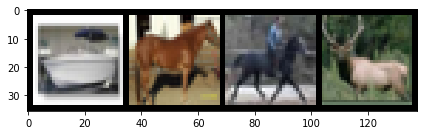

In [6]:
ut.data_stats()

In [7]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)


expample_transform = ut.AlbumentationTransforms([
                                                A.PadIfNeeded(min_height=32+8, min_width=32+8, border_mode=cv2.BORDER_CONSTANT,
                                                              value=channel_means, p=1.0),          
                                                A.RandomCrop(height=32, width=32, always_apply=False, p=1.0),
                                                A.CoarseDropout(max_holes = 1, max_height=16, max_width=16,  
                                                                min_holes = 1, min_height=16, min_width=16,  
                                                                fill_value=channel_means, mask_fill_value = None),
                                                A.Normalize(mean=channel_means, std=channel_stdevs)
                                       ])

Files already downloaded and verified


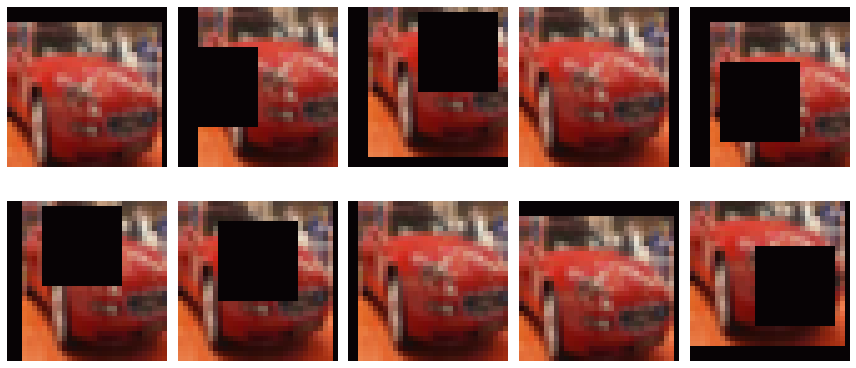

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True)
random.seed(42)
ut.visualize_augmentations(trainset,expample_transform,5 )

In [9]:
channel_means = (0.4919, 0.4827, 0.4472)
channel_stdevs = (0.2470, 0.2434, 0.2616)

train_transforms = ut.AlbumentationTransforms([
                                                A.PadIfNeeded(min_height=32+8, min_width=32+8, border_mode=cv2.BORDER_CONSTANT,
                                                              value=channel_means, p=1.0),          
                                                A.RandomCrop(height=32, width=32, always_apply=False, p=1.0),
                                                A.CoarseDropout(max_holes = 1, max_height=16, max_width=16,  
                                                                min_holes = 1, min_height=16, min_width=16,  
                                                                fill_value=channel_means, mask_fill_value = None),
                                                A.Normalize(mean=channel_means, std=channel_stdevs)
                                              ])
# Test Phase transformations
test_transforms = ut.AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

In [10]:
classes, trainloader, testloader = m.load(train_transforms,test_transforms)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


2. Define a Convolution Neural Network




In [11]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = models.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           1,728
       BatchNorm2d-2           [-1, 64, 56, 56]             128
            Conv2d-3           [-1, 64, 56, 56]          36,864
       BatchNorm2d-4           [-1, 64, 56, 56]             128
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
        BasicBlock-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
       BasicBlock-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 128, 28, 28]          73,728
      BatchNorm2d-14          [-1,

3. Define a Loss function and optimizer. Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [12]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

model = models.ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=12, gamma=0.1)

In [13]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

EPOCHS = 20

In [14]:
m.train_test_loop(model,device,trainloader,testloader,criterion,optimizer,train_losses,train_accuracy,test_losses,test_accuracy,EPOCHS)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.01


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.295666217803955 Batch_id=390 Accuracy=39.82: 100%|██████████| 391/391 [02:09<00:00,  3.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 4950/10000 (49.50%)

EPOCH: 2 LR: 0.01


Loss=0.9026527404785156 Batch_id=390 Accuracy=55.94: 100%|██████████| 391/391 [02:15<00:00,  2.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 5638/10000 (56.38%)

EPOCH: 3 LR: 0.01


Loss=0.9701749682426453 Batch_id=390 Accuracy=63.71: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 6345/10000 (63.45%)

EPOCH: 4 LR: 0.01


Loss=0.9290801882743835 Batch_id=390 Accuracy=69.26: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6863/10000 (68.63%)

EPOCH: 5 LR: 0.01


Loss=0.5708011984825134 Batch_id=390 Accuracy=72.65: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0078, Accuracy: 6919/10000 (69.19%)

EPOCH: 6 LR: 0.01


Loss=0.6396053433418274 Batch_id=390 Accuracy=75.15: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7658/10000 (76.58%)

EPOCH: 7 LR: 0.01


Loss=0.5974408388137817 Batch_id=390 Accuracy=77.18: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0095, Accuracy: 6334/10000 (63.34%)

EPOCH: 8 LR: 0.01


Loss=0.544719398021698 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7796/10000 (77.96%)

EPOCH: 9 LR: 0.01


Loss=0.5840063691139221 Batch_id=390 Accuracy=80.08: 100%|██████████| 391/391 [02:15<00:00,  2.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8054/10000 (80.54%)

EPOCH: 10 LR: 0.01


Loss=0.6200582981109619 Batch_id=390 Accuracy=81.34: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8206/10000 (82.06%)

EPOCH: 11 LR: 0.01


Loss=0.4921296238899231 Batch_id=390 Accuracy=82.56: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8079/10000 (80.79%)

EPOCH: 12 LR: 0.01


Loss=0.5821204781532288 Batch_id=390 Accuracy=83.63: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8393/10000 (83.93%)

EPOCH: 13 LR: 0.01


Loss=0.37460726499557495 Batch_id=390 Accuracy=84.34: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8194/10000 (81.94%)

EPOCH: 14 LR: 0.01


Loss=0.47428447008132935 Batch_id=390 Accuracy=84.78: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8435/10000 (84.35%)

EPOCH: 15 LR: 0.01


Loss=0.3500897288322449 Batch_id=390 Accuracy=85.63: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8496/10000 (84.96%)

EPOCH: 16 LR: 0.01


Loss=0.43720030784606934 Batch_id=390 Accuracy=86.36: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8262/10000 (82.62%)

EPOCH: 17 LR: 0.01


Loss=0.3384072482585907 Batch_id=390 Accuracy=86.75: 100%|██████████| 391/391 [02:15<00:00,  2.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8427/10000 (84.27%)

EPOCH: 18 LR: 0.01


Loss=0.37322336435317993 Batch_id=390 Accuracy=87.49: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8559/10000 (85.59%)

EPOCH: 19 LR: 0.01


Loss=0.38451194763183594 Batch_id=390 Accuracy=87.97: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 7945/10000 (79.45%)

EPOCH: 20 LR: 0.01


Loss=0.3949025869369507 Batch_id=390 Accuracy=88.44: 100%|██████████| 391/391 [02:16<00:00,  2.87it/s]



Test set: Average loss: 0.0030, Accuracy: 8803/10000 (88.03%)



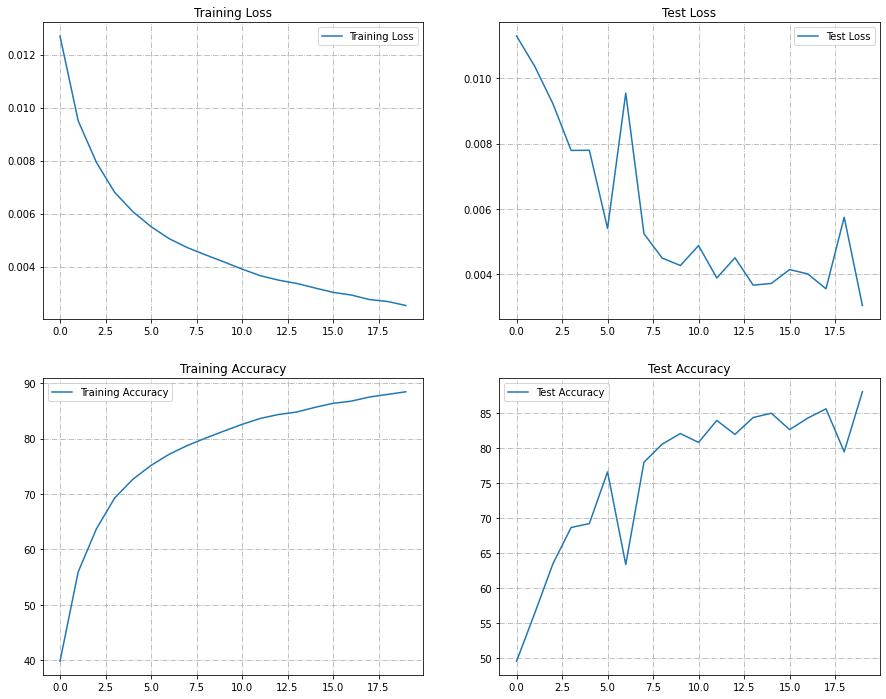

In [15]:
ut.plot_loss_accurracy(train_losses,train_accuracy, test_losses,  test_accuracy)

Plotting the misclassified image

In [16]:
misclassified_images = []
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

ut.evaluate_accuracy(model,device,testloader,misclassified_images,classes, correct_pred, total_pred )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


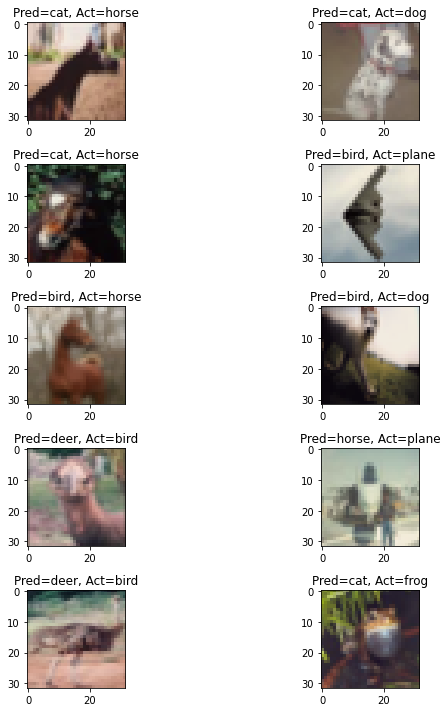

Accuracy for class plane is: 84.7 %
Accuracy for class car   is: 96.6 %
Accuracy for class bird  is: 85.4 %
Accuracy for class cat   is: 77.8 %
Accuracy for class deer  is: 87.3 %
Accuracy for class dog   is: 83.7 %
Accuracy for class frog  is: 84.3 %
Accuracy for class horse is: 92.8 %
Accuracy for class ship  is: 94.8 %
Accuracy for class truck is: 92.9 %


In [17]:
ut.show_misclassified_images(misclassified_images,classes, correct_pred, total_pred )

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


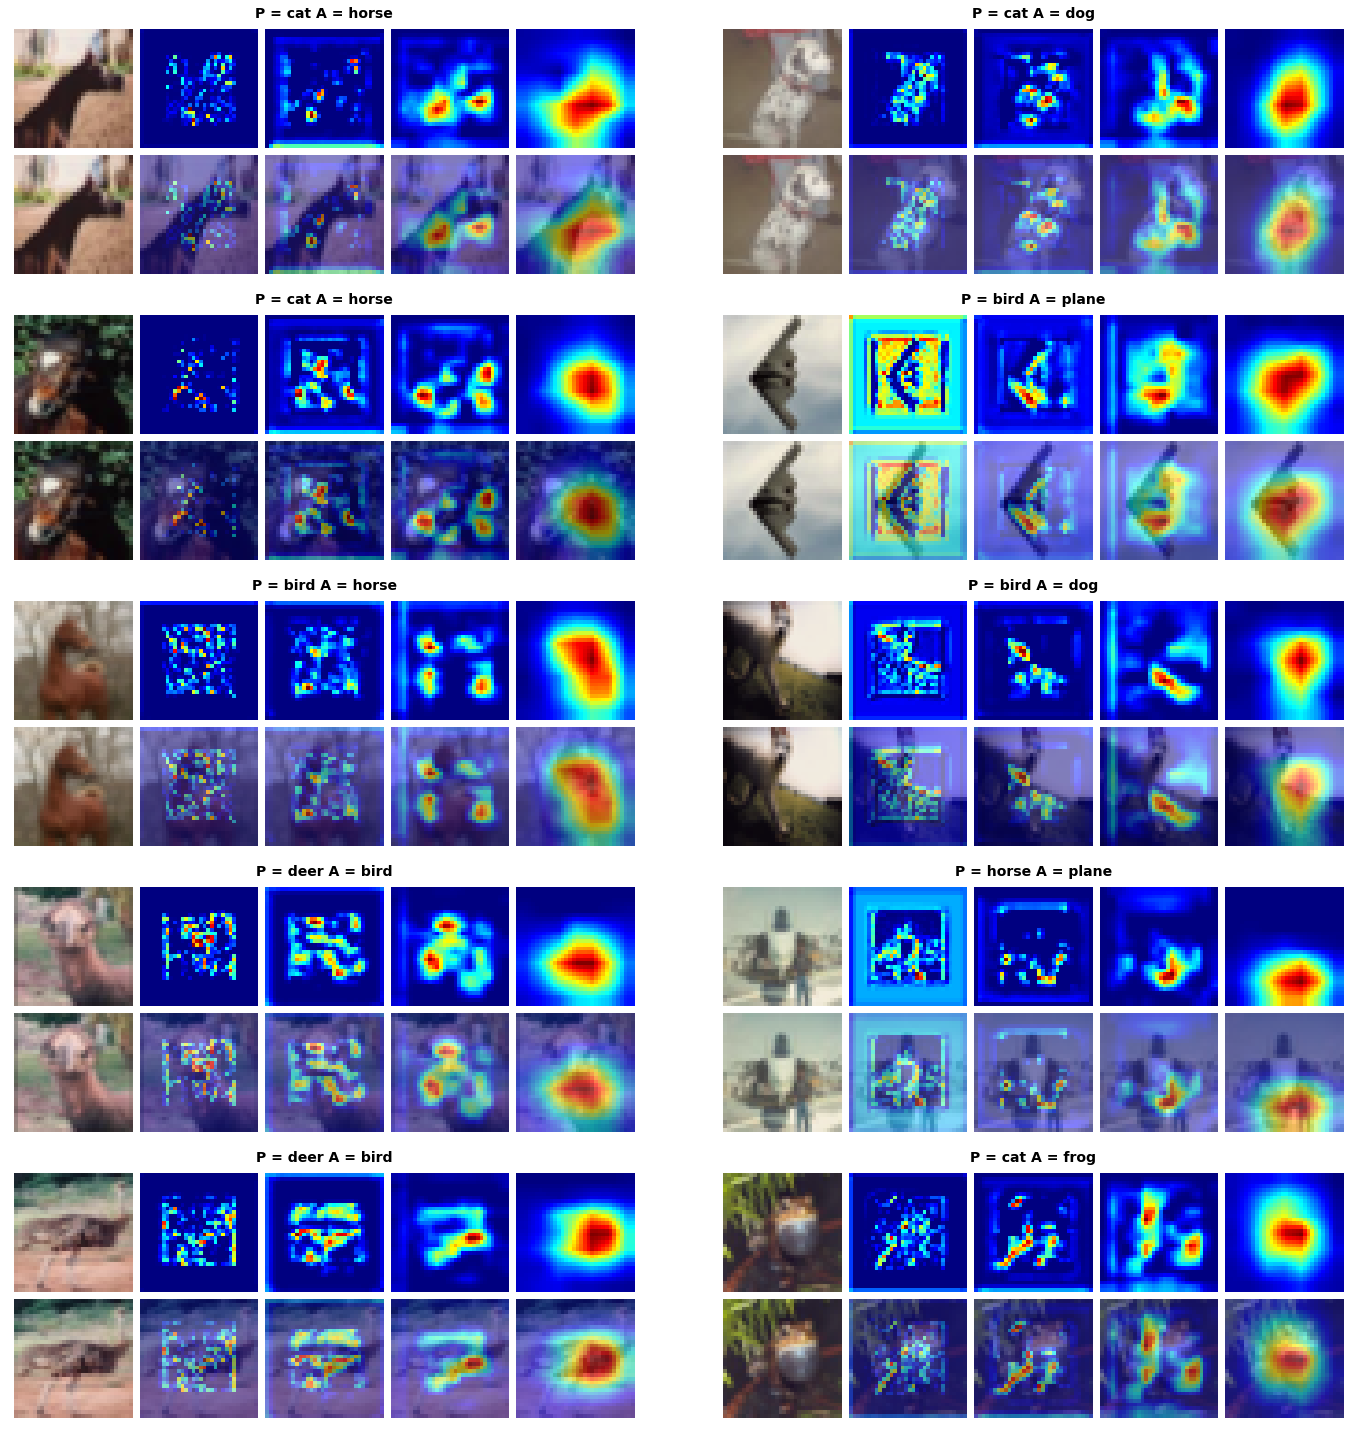

In [18]:
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
ut.GradCamView(misclassified_images,model,classes,layers)